In [19]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from datetime import datetime




In [20]:
#Define paths
currentDir = os.getcwd()
accelerometerDataPath = os.path.join(currentDir, "data", "all_accelerometer_data_pids_13.csv")
tacDataPath = os.path.join(currentDir, "data", "clean_tac")
phoneTypesPath = os.path.join(currentDir, "data", "phone_types.csv")

In [21]:
#Combine clean_tac into one dataframe
csvFiles = glob.glob(os.path.join(tacDataPath, '*.csv'))
print(csvFiles)
tacDataFrames = []

for csvFile in csvFiles:
    tacDataFrames.append(pd.read_csv(csvFile))

['c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BK7610_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BU4707_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\CC6740_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DC6359_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DK3500_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\HV0618_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JB3156_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JR8022_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\MC7070_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive

In [22]:
#Loading data files

tacData = pd.concat(tacDataFrames, ignore_index=True)
accelerometerData = pd.read_csv(accelerometerDataPath)
phoneTypes = pd.read_csv(phoneTypesPath)

In [23]:
#Check dataframes
tacData.head()
accelerometerData.head()
phoneTypes.head()


,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone


In [24]:
#Check for null
tacData.isnull().sum()
accelerometerData.isnull().sum()
phoneTypes.isnull().sum()

pid          0
phonetype    0
dtype: int64

In [25]:
print(tacData)

      timestamp  TAC_Reading
0    1493718714    -0.000482
1    1493720697     0.001573
2    1493721027     0.002144
3    1493721357     0.000877
4    1493721686    -0.001145
..          ...          ...
710  1493797974     0.029049
711  1493799820     0.016286
712  1493801652     0.004243
713  1493803481    -0.001995
714  1493805310    -0.002919

[715 rows x 2 columns]


In [26]:
#Connect accelerometer data with their respective phone types
accelerometerData = accelerometerData.merge(phoneTypes, on='pid')
print(accelerometerData)

                  time     pid         x         y         z phonetype
0                    0  JB3156  0.000000  0.000000  0.000000   Android
1                    0  CC6740  0.000000  0.000000  0.000000   Android
2        1493733882409  SA0297  0.075800  0.027300 -0.010200    iPhone
3        1493733882455  SA0297 -0.035900  0.079400  0.003700    iPhone
4        1493733882500  SA0297 -0.242700 -0.086100 -0.016300    iPhone
...                ...     ...       ...       ...       ...       ...
1048570  1493742311425  JB3156 -0.790259 -0.879167 -0.254394   Android
1048571  1493742311430  HV0618 -0.036200 -0.085200  0.005500    iPhone
1048572  1493742311430  BK7610 -0.217200 -0.184400 -0.434500    iPhone
1048573  1493742311433  SF3079  0.030300  0.098100  0.098000    iPhone
1048574  1493742311440  CC6740  0.020966 -0.010933  0.145366   Android

[1048575 rows x 6 columns]


In [27]:
#Identify bar crawl events (increased movement)
segmentLength = 60
barCrawlEvents = []

tacData['timestamp'] *= 1000
print(tacData)

print(accelerometerData)

         timestamp  TAC_Reading
0    1493718714000    -0.000482
1    1493720697000     0.001573
2    1493721027000     0.002144
3    1493721357000     0.000877
4    1493721686000    -0.001145
..             ...          ...
710  1493797974000     0.029049
711  1493799820000     0.016286
712  1493801652000     0.004243
713  1493803481000    -0.001995
714  1493805310000    -0.002919

[715 rows x 2 columns]
                  time     pid         x         y         z phonetype
0                    0  JB3156  0.000000  0.000000  0.000000   Android
1                    0  CC6740  0.000000  0.000000  0.000000   Android
2        1493733882409  SA0297  0.075800  0.027300 -0.010200    iPhone
3        1493733882455  SA0297 -0.035900  0.079400  0.003700    iPhone
4        1493733882500  SA0297 -0.242700 -0.086100 -0.016300    iPhone
...                ...     ...       ...       ...       ...       ...
1048570  1493742311425  JB3156 -0.790259 -0.879167 -0.254394   Android
1048571  1493742311430  

In [41]:
# Initialize an empty DataFrame to store all participants' data
all_participants_data = pd.DataFrame(columns=accelerometerData.columns)

# Iterate through participants data
for participant_id, participant_data in accelerometerData.groupby('pid'):
    # Calculate magnitude for each participant
    participant_data['magnitude'] = np.sqrt(participant_data['x']**2 + participant_data['y']**2 + participant_data['z']**2)
    
    # Check if participant_data contains any valid entries
    if not participant_data.empty and not participant_data.isnull().all().all():
        # Append participant data to the DataFrame containing all participants' data
        all_participants_data = pd.concat([all_participants_data, participant_data], ignore_index=True)

# Define threshold
threshold = 0.01  # Adjust threshold value as needed

# Identify segments
segments = []
segment_start = None
current_id = None

for index, row in all_participants_data.iterrows():
    if row['magnitude'] > threshold:
        if segment_start is None:
            segment_start = row['time']
            current_id = row['pid']
    else:
        if segment_start is not None:
            segment_end = row['time']
            segments.append((current_id, segment_start, segment_end))
            segment_start = None
            current_id = None

# Create DataFrame for segments
barCrawlEventsDf = pd.DataFrame(segments, columns=['id', 'segment_start', 'segment_end'])

print(barCrawlEventsDf)

C:\Users\heath\AppData\Local\Temp\ipykernel_10660\4219901733.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_participants_data = pd.concat([all_participants_data, participant_data], ignore_index=True)


           id  segment_start    segment_end
0      BK7610  1493735870653  1493735872504
1      BK7610  1493735872531  1493735872753
2      BK7610  1493735872780  1493735872881
3      BK7610  1493735872904  1493735873104
4      BK7610  1493735873129  1493735873232
...       ...            ...            ...
28551  SF3079  1493742256447  1493742257316
28552  SF3079  1493742257351  1493742287665
28553  SF3079  1493742287709  1493742288129
28554  SF3079  1493742288159  1493742288235
28555  SF3079  1493742288295  1493742288460

[28556 rows x 3 columns]


In [45]:
# Define the TAC threshold
tacThreshold_withThresh = 0.08

# Define tolerance in milliseconds
tolerance_ms = 60 * 10**9  # Adjust tolerance as needed

# Merge barCrawlEventsDF with tacdata based on timestamps
merged_data = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start'), 
                            tacData.sort_values('timestamp'), 
                            left_on='segment_start', 
                            right_on='timestamp', 
                            direction='nearest',
                            tolerance=tolerance_ms)

# Filter the merged data to include only rows where the TAC reading is above the threshold
filtered_data_above_threshold = merged_data[merged_data['TAC_Reading'] >= tacThreshold_withThresh]
filtered_data_below_threshold = merged_data[merged_data['TAC_Reading'] < tacThreshold_withThresh]
filtered_aboveMergeData = merged_data[merged_data['TAC_Reading'] >= 0]

# Print the counts
above_count = filtered_data_above_threshold.shape[0]
below_count = filtered_data_below_threshold.shape[0]

print("Number of bar crawl events above 0.08 TAC readings:", above_count)
print("Number of bar crawl events below 0.08 TAC readings:", below_count)

# Determine which category occurs more frequently
if above_count > below_count:
    print("Bar crawl events above 0.08 TAC readings occur more frequently.")
elif above_count < below_count:
    print("Bar crawl events below 0.08 TAC readings occur more frequently.")
else:
    print("Bar crawl events above and below 0.08 TAC readings occur with equal frequency.")

Number of bar crawl events above 0.08 TAC readings: 5150
Number of bar crawl events below 0.08 TAC readings: 23406
Bar crawl events below 0.08 TAC readings occur more frequently.


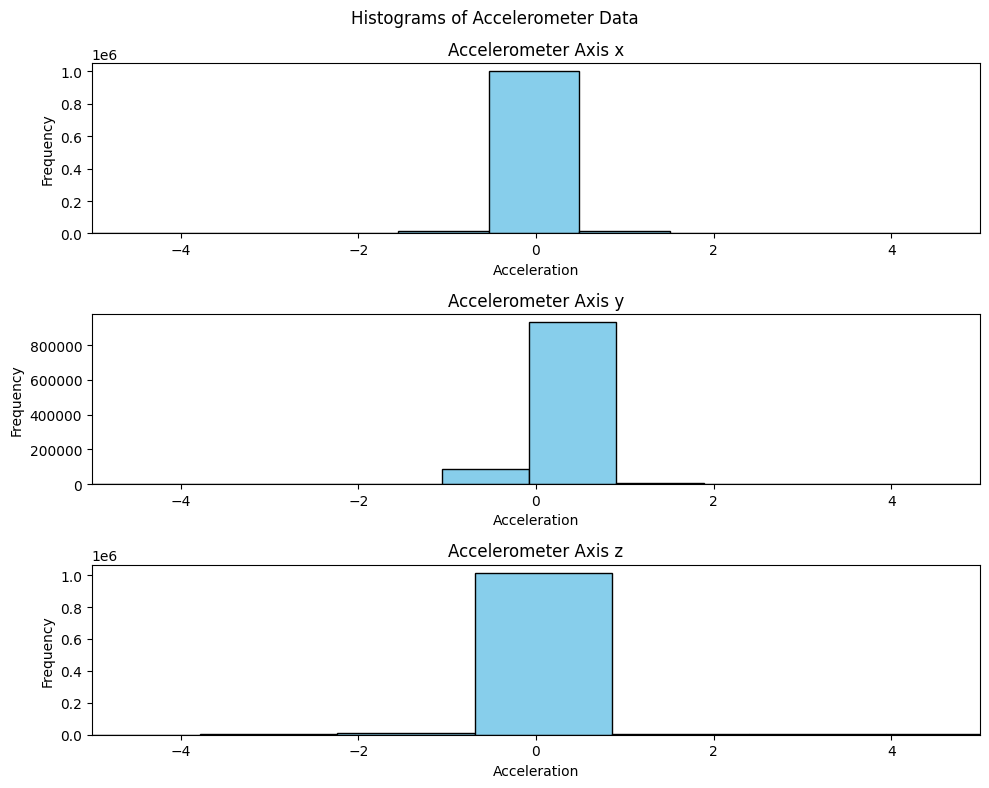

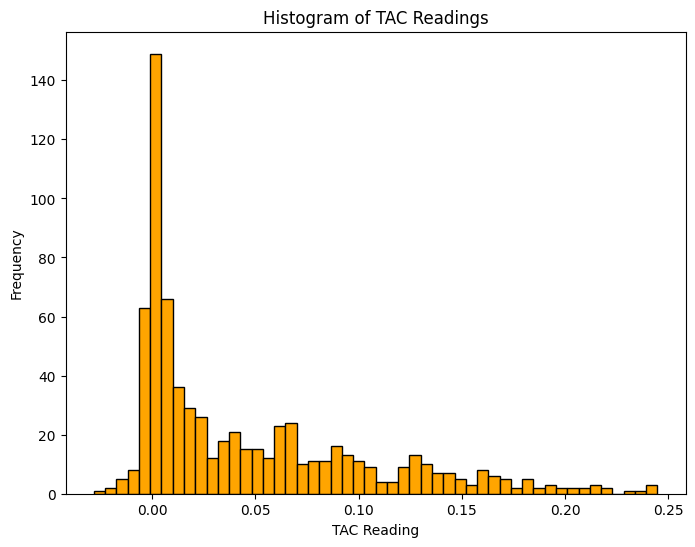

In [30]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

#Plot histograms
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].hist(accelerometerData[axis], bins=50, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Acceleration')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

#TAC histogram
plt.figure(figsize=(8, 6))
plt.hist(tacData['TAC_Reading'], bins=50, color='orange', edgecolor='black')
plt.title('Histogram of TAC Readings')
plt.xlabel('TAC Reading')
plt.ylabel('Frequency')
plt.show()

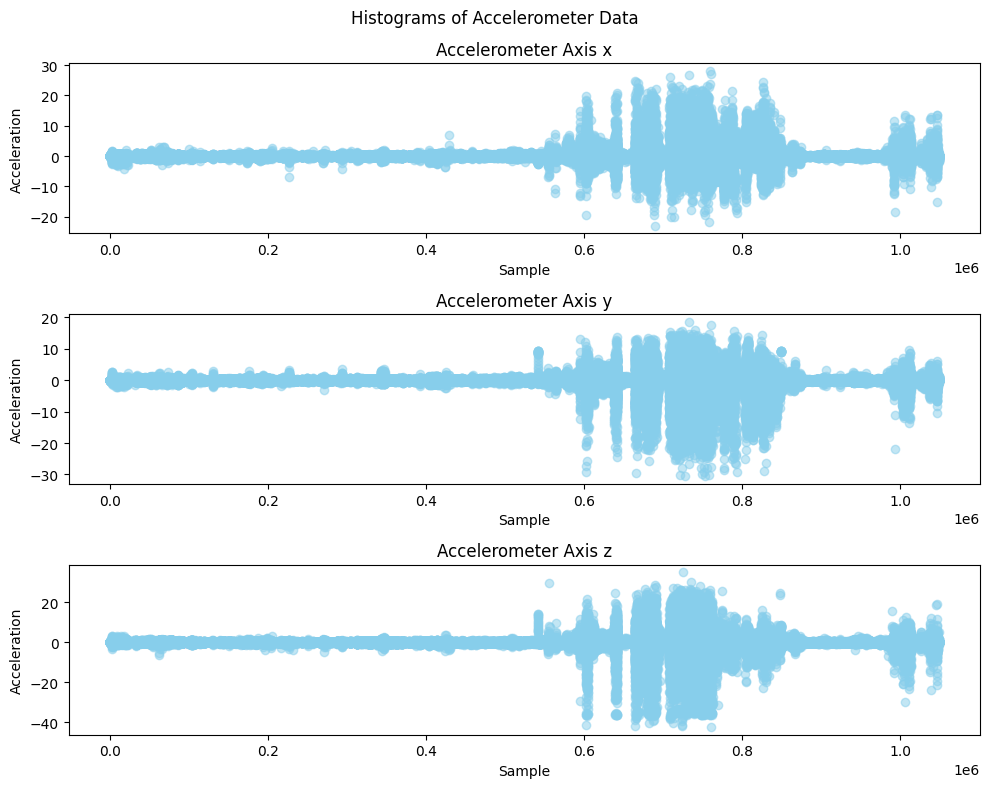

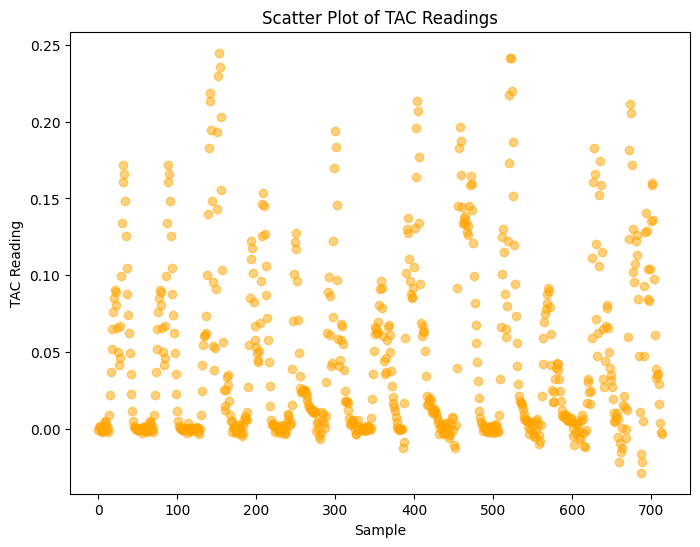

In [31]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

# Plot scatter plots for accelerometer data
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].scatter(range(len(accelerometerData[axis])), accelerometerData[axis], color='skyblue', alpha=0.5)
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Sample')
    axs[i].set_ylabel('Acceleration')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(len(tacData['TAC_Reading'])), tacData['TAC_Reading'], color='orange', alpha=0.5)
plt.title('Scatter Plot of TAC Readings')
plt.xlabel('Sample')
plt.ylabel('TAC Reading')
plt.show()

In [32]:
#EDA
filtered_aboveMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']
filtered_belowMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']
print(filtered_aboveMergeData.columns)
X = filtered_aboveMergeData[['total_time', 'TAC_Reading']]
y = (filtered_aboveMergeData['TAC_Reading'] >= 0.08)
#print(aboveMergeData['heavy_drinking_episode'])

print(X)
print(y)

Index(['id', 'segment_start', 'segment_end', 'timestamp', 'TAC_Reading',
       'total_time'],
      dtype='object')
       total_time  TAC_Reading
72             45     0.089366
1329          181     0.059162
1887           75     0.007368
1953          249     0.181307
2936          150     0.110832
4298       303282     0.007239
4474           50     0.065357
4475           26     0.065357
4499           77     0.005702
8317          197     0.025131
9232        25158     0.008935
9242         2683     0.008935
9283         9034     0.061333
11240       83231     0.035549
11291       47911     0.027723
11325       37454     0.027723
11431      122814     0.085197
11579          75     0.085197
11748       45928     0.171436
11751       60350     0.041870
14245        4783     0.082124
14258         100     0.082124
14259          50     0.082124
14260          65     0.082124
15706         150     0.040862
15707          60     0.040862
15708          50     0.040862
72        True


C:\Users\heath\AppData\Local\Temp\ipykernel_10660\946729717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_aboveMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']
C:\Users\heath\AppData\Local\Temp\ipykernel_10660\946729717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_belowMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']


In [33]:
#Handle any NA 
X = X.fillna(X.mean())

In [34]:
#Train-test split
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)

print(reg.coef_)
print(reg.intercept_)
print(reg.coef_.shape[0])

reg.fit(X_train,y_train)
reg.score(X_test,y_test)
reg.score(X_test,y_test)

(21, 2)
(6, 2)
(21,)
(6,)
[6.35605315e-07 8.42416958e+00]
-0.19053972015008747
2


0.6249626618217006

In [35]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_reg = LogisticRegression()

logistic_reg.fit(X_train, y_train)

y_pred = logistic_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6666666666666666


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


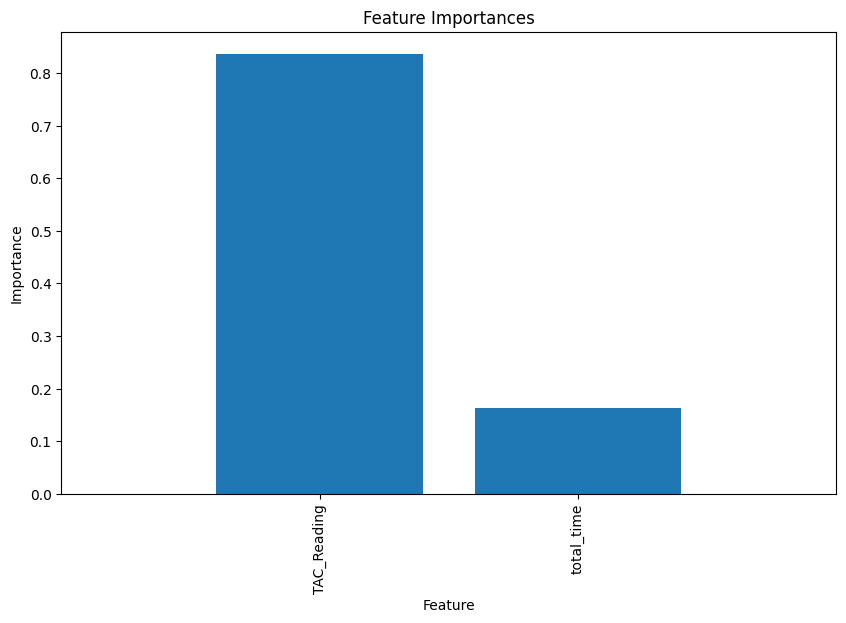

In [37]:
import matplotlib.pyplot as plt

feature_importances = random_forest.feature_importances_

feature_names = X.columns

indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()